In [6]:
import pandas as pd
import numpy as np
df = pd.read_json("250k.docs.jsonl", lines=True)

In [3]:
df.columns

ERROR! Session/line number was not unique in database. History logging moved to new session 476


NameError: name 'df' is not defined

In [ ]:
df.DocType.unique()

In [ ]:
papers = df[(df.DocType == "Journal") | (df.DocType == "Conference")]

In [7]:
papers.columns

Index(['PaperId', 'Title', 'Rank', 'CitationCount', 'Doi', 'DocType',
       'BookTitle', 'Volume', 'Issue', 'FirstPage', 'LastPage',
       'PublishedDate', 'Publisher', 'Journal', 'Authors', 'FieldsOfStudy',
       'Urls', 'PdfUrl', 'Abstract'],
      dtype='object')

In [8]:
papers["FirstPage"] = papers.FirstPage.apply(lambda x: x.split("-")[-1] if x else np.nan)

In [9]:
papers["LastPage"] = papers.LastPage.apply(lambda x: x.split("-")[-1] if x else np.nan)

In [10]:
papers["Length"] = pd.to_numeric(papers.LastPage) - pd.to_numeric(papers.FirstPage)

In [11]:
papers = papers.drop(columns=["Urls", "PdfUrl", "Doi", "Volume", "Issue", "FirstPage", "LastPage", "BookTitle", "PaperId"])

In [12]:
papers.iloc[0].Authors

[{'Name': 'F. Motoyoshi', 'AuthorId': '2632896860', 'SequenceNumber': 1},
 {'Name': 'N. Oshima', 'AuthorId': '2708987407', 'SequenceNumber': 2}]

In [13]:
papers.iloc[0].FieldsOfStudy

[{'Name': 'tobacco mosaic virus', 'Level': 3},
 {'Name': 'virus', 'Level': 2},
 {'Name': 'protoplast', 'Level': 2},
 {'Name': 'virology', 'Level': 1},
 {'Name': 'botany', 'Level': 1},
 {'Name': 'biology', 'Level': 0}]

In [14]:
authors = set()
for i, row in papers.iterrows():
    for entry in row.Authors:
        authors.add(entry["AuthorId"])

In [15]:
len(authors)

533118

In [16]:
major_fields = set()
no_major_fields = set()
minor_fields = set()
topics = set()
problems = set()
for i, row in papers.iterrows():
    major_amount = 0
    for entry in row.FieldsOfStudy:
        if entry["Level"] == 0:
            major_fields.add(entry["Name"])
            major_amount += 1
        elif entry["Level"] == 1:
            minor_fields.add(entry["Name"])
        elif entry["Level"] == 2:
            topics.add(entry["Name"])
        else:
            problems.add(entry["Name"])
    no_major_fields.add(major_amount)

In [17]:
print(f"Major Fields: {len(major_fields)}, Amounts: {no_major_fields}")
print(f"Minor Fields: {len(minor_fields)}")
print(f"Topics: {len(topics)}")
print(f"Problems: {len(problems)}")

Major Fields: 19, Amounts: {0, 1, 2, 3}
Minor Fields: 294
Topics: 28274
Problems: 49262


In [18]:
majors = []
minors = []
journals = []
for i, row in papers.iterrows():
    major_fields = []
    minor_fields = []
    journal_entry = row.Journal
    for entry in row.FieldsOfStudy:
        level = entry["Level"]
        name = entry["Name"]
        if level == 0:
            major_fields.append(name)
        elif level == 1:
            minor_fields.append(name)
    majors.append(major_fields)
    minors.append(minor_fields)
    journals.append(journal_entry["JournalName"] if journal_entry else np.nan)
    
papers["MajorFields"] = majors
papers["MinorFields"] = minors
papers["Journal"] = journals

In [19]:
papers = papers.drop(columns=["Authors", "FieldsOfStudy", "PublishedDate"])[papers.MajorFields.apply(lambda x: len(x)) == 1]

In [20]:
papers["MajorFields"] = papers.MajorFields.apply(lambda x: x[0])

<AxesSubplot:xlabel='% Total', ylabel='MajorFields'>

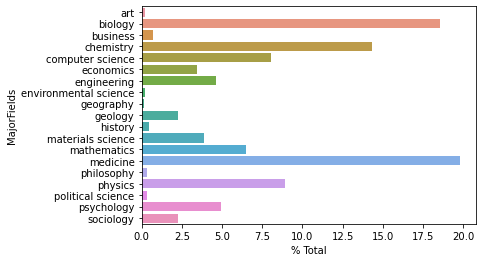

In [21]:
import seaborn as sns
sns.barplot(x=papers.groupby("MajorFields").count()["Title"].rename("% Total") /  papers.shape[0] * 100, y=papers.groupby("MajorFields").count().index)

<AxesSubplot:xlabel='Total', ylabel='MajorFields'>

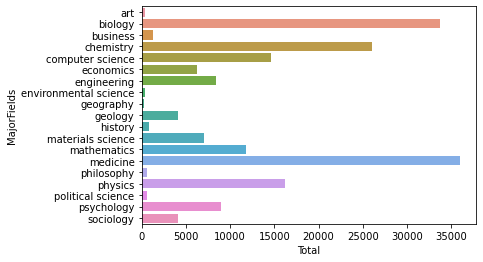

In [22]:
sns.barplot(x=papers.groupby("MajorFields").count()["Title"].rename("Total"), y=papers.groupby("MajorFields").count().index)

In [23]:
papers.head(4)

,Title,Rank,CitationCount,DocType,Publisher,Journal,Abstract,Length,MajorFields,MinorFields
0,Infection with Tobacco Mosaic Virus of Leaf Me...,22568,101,Journal,Microbiology Society,Journal of General Virology,Summary\nA procedure was developed to isolate ...,10.0,biology,"[virology, botany]"
2,An indigenous cluster beam apparatus with a re...,21730,6,Journal,Indian Academy of Sciences,Journal of Chemical Sciences,The design and fabrication of a Smalley-type c...,12.0,chemistry,"[analytical chemistry, nuclear magnetic resona..."
5,Determination of Plasma Dexamethasone in the M...,22203,76,Journal,The Endocrine Society,The Journal of Clinical Endocrinology and Meta...,A RIA method is described for the measurement ...,6.0,medicine,"[endocrinology, internal medicine]"
6,Women and radio,22912,16,Journal,Pergamon,Women's Studies International Quarterly,Synopsis The relationship between women and ...,13.0,sociology,[advertising]


In [24]:
no_na_rows = len(papers) - len(papers.dropna())
print(f"{round(no_na_rows/len(papers)*1000)/10}% NaN rows")

20.8% NaN rows


In [25]:
# For now just interpolate values
papers = papers.interpolate()

In [26]:
papers["Abstract"] = papers.Abstract.apply(lambda x: x.lower())

In [27]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import words as englishwords
from nltk.stem import WordNetLemmatizer
def tokenize(string, lower=True, punctuation=True, stops=True, lemmatize=True, check_english=False):
    """Tokenise a string into a vector"""
    stop_words = set(stopwords.words("english"))
    english_words = set(englishwords.words())
    words = word_tokenize(string)
    lzr = WordNetLemmatizer() 

    # Remove Lower Case
    if lower:
        words = [w.lower() for w in words]
    # Remove Punctuation
    if punctuation:
        words = [w for w in words if w.isalnum()]
    # Remove Stop Words
    if stops:
        words = [w for w in words if w not in stop_words]
    # Lemmatise
    if lemmatize:
        words = [lzr.lemmatize(w) for w in words]
    # Check if word is Enlgish; Takes long to run, use with caution
    if check_english:
        words = [w for w in words if w in english_words]
    return words

In [28]:
papers["Abstract"] = papers.Abstract.apply(tokenize)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [27]:
papers.Abstract

0         [summary, procedure, developed, isolate, tomat...
2         [design, fabrication, cluster, source, combina...
5         [ria, method, described, measurement, dexameth...
6         [synopsis, relationship, women, radio, greatly...
7         [paper, presents, results, obtained, review, a...
                                ...                        
249992    [1900, physicist, henri, benard, exhibited, sp...
249993    [purpose, based, recent, polysomnographic, psg...
249995    [traditional, strategies, based, competition, ...
249996    [present, method, multiplication, finite, fiel...
249998    [dependences, calculating, hydrodynamic, chara...
Name: Abstract, Length: 181751, dtype: object

In [ ]:
papers.to_csv("processed_250k", index=False)

Author Citation Count/Mean/Highest per entry

In [7]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
magbin = label_encoder.fit_transform(pd.cut(papers.Rank, 6, retbins=True)[0])

In [8]:
papers["MagBin"] = magbin

In [14]:
papers.MagBin.describe()

count    182007.000000
mean          1.145983
std           0.392808
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           5.000000
Name: MagBin, dtype: float64

In [19]:
magbin = pd.get_dummies(magbin) 

In [22]:
magbin.columns = [f"Rank_{i}" for i in range(6)]

In [27]:
pd.merge(papers, magbin, left_index=True, right_index=True)

,PaperId,Title,Rank,CitationCount,Doi,DocType,BookTitle,Volume,Issue,FirstPage,...,Urls,PdfUrl,Abstract,MagBin,Rank_0,Rank_1,Rank_2,Rank_3,Rank_4,Rank_5
0,2013265920,Infection with Tobacco Mosaic Virus of Leaf Me...,22568,101,10.1099/0022-1317-29-1-81,Journal,None,29.0,1.0,81,...,[http://jgv.microbiologyresearch.org/content/j...,http://jgv.microbiologyresearch.org/deliver/fu...,Summary\nA procedure was developed to isolate ...,1,0,1,0,0,0,0
2,2013266099,An indigenous cluster beam apparatus with a re...,21730,6,10.1007/BF02704310,Journal,None,112.0,2.0,83,...,[https://link.springer.com/article/10.1007/BF0...,None,The design and fabrication of a Smalley-type c...,1,0,1,0,0,0,0
5,2013266397,Determination of Plasma Dexamethasone in the M...,22203,76,10.1210/jcem-56-1-127,Journal,None,56.0,1.0,127,...,"[https://www.ncbi.nlm.nih.gov/pubmed/6336618, ...",None,A RIA method is described for the measurement ...,1,0,1,0,0,0,0
6,2013266476,Women and radio,22912,16,10.1016/S0148-0685(80)92575-0,Journal,None,3.0,1.0,41,...,[https://www.sciencedirect.com/science/article...,None,Synopsis The relationship between women and ...,1,0,1,0,0,0,0
7,2013266597,The Copper Age Settlement of Valencina de la C...,20663,22,10.3989/tp.2010.10032,Journal,None,67.0,1.0,85,...,[http://tp.revistas.csic.es/index.php/tp/artic...,http://tp.revistas.csic.es/index.php/tp/articl...,This paper presents the results obtained from ...,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181999,2166153631,Renal dysfunction in chronic liver disease,20038,74,10.1186/cc8855,Journal,None,14.0,2.0,214,...,[https://ccforum.biomedcentral.com/articles/10...,https://ccforum.biomedcentral.com/track/pdf/10...,"Acute kidney injury (AKI), chronic kidney dise...",1,0,1,0,0,0,0
182000,2031936000,"Carp (Cyprinus carpio) muscle fructose 1,6-bis...",24910,9,10.1016/0305-0491(77)90204-8,Journal,None,58.0,3.0,291,...,[https://www.sciencedirect.com/science/article...,None,"Abstract 1. 1. Fructose 1,6-bisphosphata...",2,0,1,0,0,0,0
182001,2031936092,Cell cycle-dependent regulation of yeast telom...,19662,252,10.1038/nsmb854,Journal,None,11.0,12.0,1198,...,"[https://www.ncbi.nlm.nih.gov/pubmed/15531893,...",None,The heterodimeric Ku complex affects telomere ...,1,0,1,0,0,0,0
182003,2166154043,Temperature dependence of canine brain tissue ...,20627,97,10.3109/02656739509004949,Journal,None,11.0,1.0,73,...,[http://www.tandfonline.com/doi/abs/10.3109/02...,None,The intensity of conventional spin-echo diffus...,1,0,1,0,0,0,0


In [12]:
df[df.DocType.isna()]

,PaperId,Title,Rank,CitationCount,Doi,DocType,BookTitle,Volume,Issue,FirstPage,LastPage,PublishedDate,Publisher,Journal,Authors,FieldsOfStudy,Urls,PdfUrl,Abstract
14,1476396347,The Adventures of Gil Blas of Santillane [n.d....,24898,0,None,None,None,NaN,NaN,None,None,2012-12-05,"eScholarship Research Centre, The University o...",None,"[{'Name': 'Caitlin Stone and Jim Berryman', 'A...","[{'Name': 'library science', 'Level': 1}, {'Na...",[http://www.menziescollection.esrc.unimelb.edu...,None,The Adventures of Gil Blas of Santillane [n.d....
17,1632,Ellipsometry studies of the interfacial behavi...,23909,0,10.1533/9781845698539.4.363,None,None,NaN,NaN,363,369,1995-01-01,Woodhead Publishing Limited,None,"[{'Name': 'Fredrik Tiberg', 'AuthorId': '20397...","[{'Name': 'hydroxyethyl cellulose', 'Level': 3...",[https://www.sciencedirect.com/science/article...,None,ABSTRACT We report on the temperature-depend...
24,2281703696,Georeferenzierung der Eisenbahnlärmemissionen,25600,0,10.3929/ethz-a-005226690,None,None,4.0,NaN,None,None,2005-01-01,"ETH, Eidgenössische Technische Hochschule Züri...",None,"[{'Name': 'Urs Waldner', 'AuthorId': '27930744...","[{'Name': 'cartography', 'Level': 1}, {'Name':...",[http://e-collection.library.ethz.ch/eth/redir...,None,Das Bundesamt fur Verkehr hat den Emissionspla...
31,2281704347,Effects of breakfast and transport method to s...,23217,0,None,None,None,NaN,NaN,None,None,2010-09-01,University of Chester,None,"[{'Name': 'Alice Wiseman', 'AuthorId': '261571...","[{'Name': 'body fat percentage', 'Level': 4}, ...",[https://chesterrep.openrepository.com/handle/...,None,Alice Wiseman Objective: The purpose of this s...
39,3730,A suggestion for a multivariate concordance co...,24609,0,None,None,None,NaN,NaN,None,None,2014-04-01,Department of Economics - University Roma Tre,None,"[{'Name': 'Silvia Terzi', 'AuthorId': '2796982...","[{'Name': 'multivariate statistics', 'Level': ...",[https://ideas.repec.org/p/rtr/wpaper/0189.htm...,None,In the present paper we will introduce a coeci...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249980,2174031724,Industrial Applications of Computational Intel...,23681,0,10.1007/978-3-540-69913-2_14,None,None,NaN,NaN,375,404,2010-01-01,"Springer, Berlin, Heidelberg",None,"[{'Name': 'Arthur K. Kordon', 'AuthorId': '204...",[{'Name': 'industrial engineering and operatio...,[https://link.springer.com/content/pdf/10.1007...,None,If we follow the proverb that “the proof is in...
249981,26548228,Abortion and Equality,24553,1,10.1007/978-1-4613-2753-0_11,None,None,NaN,NaN,177,196,1984-01-01,"Springer, Boston, MA",None,"[{'Name': 'Mary B. Mahowald', 'AuthorId': '214...","[{'Name': 'abortion', 'Level': 3}, {'Name': 'f...",[https://link.springer.com/chapter/10.1007%2F9...,None,Although views on abortion are typically treat...
249985,26548806,The Physiology of Phenolic Compounds in Plants,22760,67,10.1007/978-1-4684-3372-2_16,None,None,NaN,NaN,525,556,1979-01-01,"Springer, Boston, MA",None,"[{'Name': 'Jerry W. McClure', 'AuthorId': '216...","[{'Name': 'chlorogenic acid', 'Level': 2}, {'N...",[https://link.springer.com/chapter/10.1007/978...,None,An Oriental fable tells of six blind men who f...
249994,26549961,Protection of Endangered Species Versus Free T...,24582,0,None,None,None,NaN,NaN,None,None,2009-08-22,None,None,"[{'Name': 'Ishupal Singh Kang', 'AuthorId': '2...","[{'Name': 'free trade', 'Level': 2}, {'Name': ...",[https://papers.ssrn.com/sol3/papers.cfm?abstr...,None,This paper deals with one of the most visible ...
